# Urban Sound Prediction 
### using **ANN**
### Train/Test Accuracy : **92.70%**, **86.55%**

## Step 1 : Install required libraries

In [1]:
!pip install numpy pandas
!pip install matplotlib seaborn plotly
!pip install keras scikit-learn librosa tqdm

## Step 2 : Import required libraries

In [41]:
# Basic Libraries
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

# Specific Libraries
import os
import librosa
import librosa.display
from typing import List, Tuple
from pathlib import Path
import IPython.display as ipd

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from tqdm import tqdm, trange
from tqdm.auto import tqdm

from keras.utils import to_categorical
from keras import Sequential, layers
from keras.layers import Dense , Activation , Dropout

from itertools import cycle
# Retrieve the default color palette from Matplotlib
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create a color cycle iterator from the default color palette
color_cycle = cycle(color_pal)  # Cycle will allow for looping through the colors

# Mount google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Warnings
import warnings
warnings.filterwarnings('ignore')

## Step 3 : Load and prepare the dataset

- ### Load the dataset

In [3]:
# Path the data
data_dir = '/kaggle/input/urbansound8k'

# Load the audio data
audio_csv_path = os.path.join(data_dir, 'UrbanSound8K.csv')
audio_df = pd.read_csv(audio_csv_path)
audio_df.info()
audio_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


slice_file_name    fsID      start        end  salience  fold  classID  \
5591  22601-8-0-12.wav   22601   6.000000  10.000000         2     3        8   
8697  99192-4-0-38.wav   99192  19.000000  23.000000         1    10        4   
8152   80806-2-0-0.wav   80806   0.000000   4.000000         2     5        2   
2052  148835-6-2-0.wav  148835   4.275913   5.546825         1     6        6   
5791  24347-8-0-43.wav   24347  25.620371  29.620371         2     4        8   

                 class  
5591             siren  
8697          drilling  
8152  children_playing  
2052          gun_shot  
5791             siren

- ### Extract Classes

In [10]:
classes = audio_df['class'].unique().tolist()
num_classes = len(classes)
print(f"> Number of Classes is : {num_classes}")
print(f"> Classes:\n {classes}")

> Number of Classes is : 10
> Classes:
 ['dog_bark', 'children_playing', 'car_horn', 'air_conditioner', 'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer', 'drilling']


- ### Extracts audio files

In [11]:
def extract_audio_files(path: str) -> List[Path]:
    """Extracts and returns a list of .wav audio files from the specified directory."""
    # Create a Path object
    directory = Path(path)
    
    # Use the Path object to find all .wav files in the specified directory and subdirectories
    return list(directory.rglob('*.wav'))

In [12]:
audio_files = extract_audio_files(data_dir)
print(f'> {len(audio_files)} audio files found in {data_dir}')
audio_files[:5]

> 8732 audio files found in /kaggle/input/urbansound8k


[PosixPath('/kaggle/input/urbansound8k/fold7/164797-2-0-8.wav'),
 PosixPath('/kaggle/input/urbansound8k/fold7/177537-7-2-0.wav'),
 PosixPath('/kaggle/input/urbansound8k/fold7/177729-0-0-68.wav'),
 PosixPath('/kaggle/input/urbansound8k/fold7/6902-2-0-18.wav'),
 PosixPath('/kaggle/input/urbansound8k/fold7/518-4-0-2.wav')]

## Step 4 : Exploratory Data Analysis (EDA)

- ### Number of audios in each class

In [13]:
# Create a DataFrame with class counts
labels = (audio_df['class'].value_counts().reset_index())

# Rename the columns
labels.columns = ['Class', 'Count']

# Format the Class names
labels['Class'] = labels['Class'].str.replace('_', ' ').str.capitalize()

# Sort by Count in descending order
labels.sort_values(by='Count', ascending=False, inplace=True)

# Create a Plotly bar chart
fig = px.bar(
    labels, x='Class', y='Count', title='Count of Classes', hover_data=['Class', 'Count'], color='Count')

# Customize the layout
fig.update_layout(xaxis_title='Class', yaxis_title='Count', xaxis_tickangle=-90)

# Show the figure
fig.show()

- ### Play audio file

In [16]:
def play_audio_file(file_path: str) -> tuple:
    """Plays the audio file if it exists and is a .wav file, and returns sample data and rate."""
    # Create a Path object
    file = Path(file_path)
    
    # Check if the file exists and has .wav extension
    if file.is_file() and file.suffix.lower() == '.wav':
        # Load the audio file, preserving its original sample rate
        sample, sample_rate = librosa.load(file_path, sr=None)
        
        # Display audio playback controls and log sample info
        print(f">> Playing audio    : {file_path}")
        print(f">  Sample Rate      : {sample_rate} Hz")
        
        # Return the Audio object for playback
        return ipd.Audio(sample, rate=sample_rate), sample, sample_rate
    else:
        print(f"{file_path} does not exist or is not a .wav file.")
        return None, None, None

In [17]:
audio_widget, sample, rate = play_audio_file(audio_files[0])
audio_widget

>> Playing audio    : /kaggle/input/urbansound8k/fold7/164797-2-0-8.wav
>  Sample Rate      : 48000 Hz


- ### Display audio file

In [20]:
def visualize_audio(file_path: str, color_pal: list = ['blue', 'orange', 'red']) -> None:
    """Load a .wav audio file and display its raw audio waveform, spectrogram, and MFCCs in one figure."""
    # Create a Path object
    file = Path(file_path)
    
    # Check if the file exists and has a .wav extension
    if not file.is_file() or file.suffix.lower() != '.wav':
        return ValueError(f"{file_path} does not exist or is not a .wav file.")
    
    # Load the audio file
    sample, sample_rate = librosa.load(file_path, sr=None)  # Use sr=None to preserve original sampling rate

    # Create figure with three subplots
    n_plots = 2
    fig, axs = plt.subplots(n_plots, 1, figsize=(16, n_plots * 4))

    # Plot the Waveform of audio
    librosa.display.waveshow(sample, sr=sample_rate, ax=axs[0], color=color_pal[0])
    axs[0].set_title("Waveform of Audio")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Amplitude")

    # Compute Short-Time Fourier Transform (STFT)
    D = librosa.stft(sample)
    # Convert amplitude to decibels
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # Plot the spectrogram of audio 
    spect_img = librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='log', ax=axs[1])
    axs[1].set_title("Spectrogram (dB)")
    plt.colorbar(spect_img, ax=axs[1], format='%+2.0f dB')
    axs[1].set_ylabel("Frequency")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

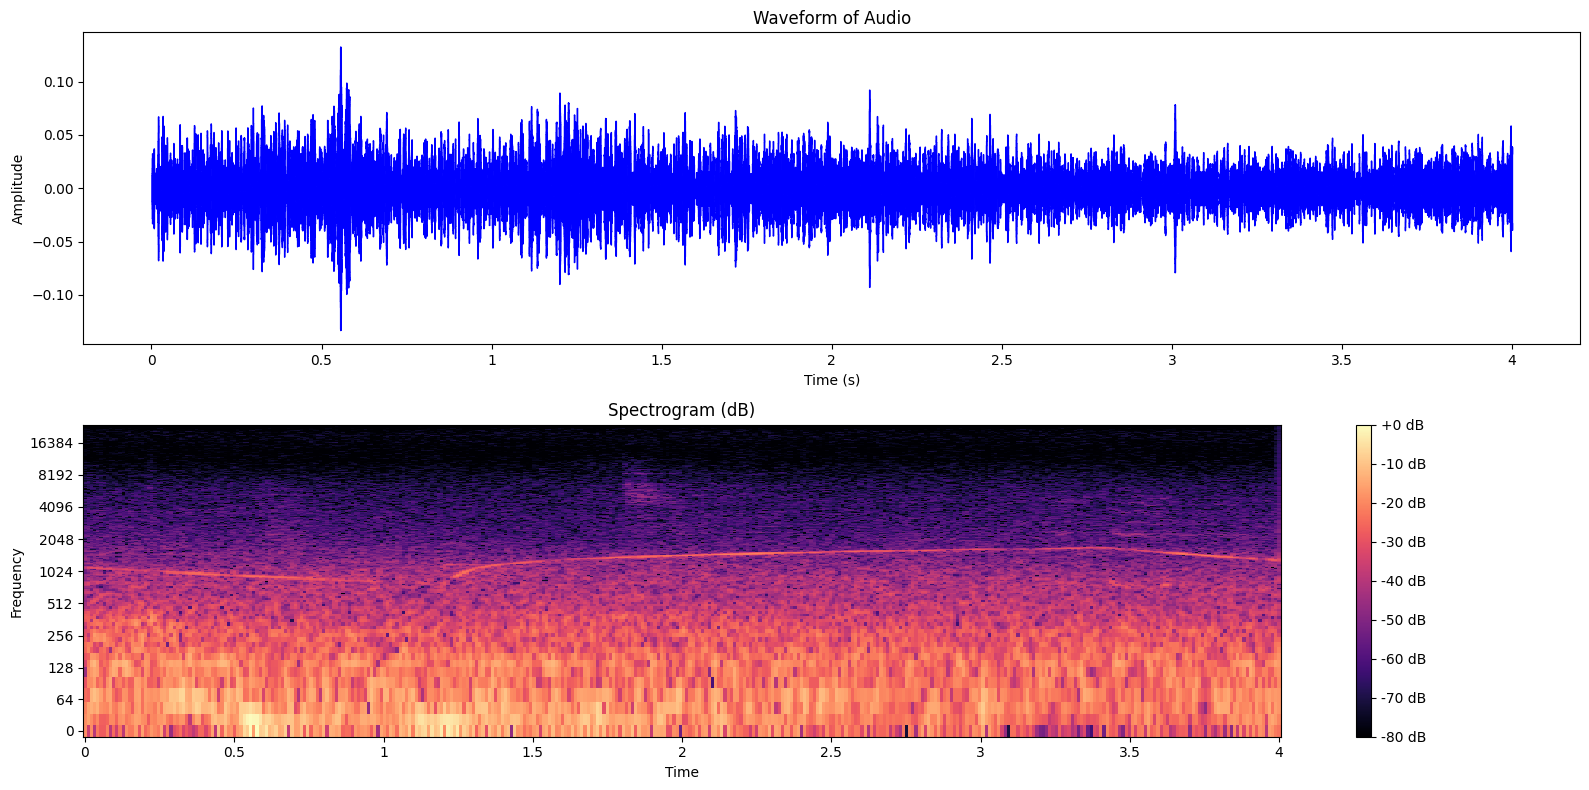

In [21]:
# display_audio usage:
visualize_audio(audio_files[0])

- ### Display audio files of each class

>>>> Audio of Air conditioner :


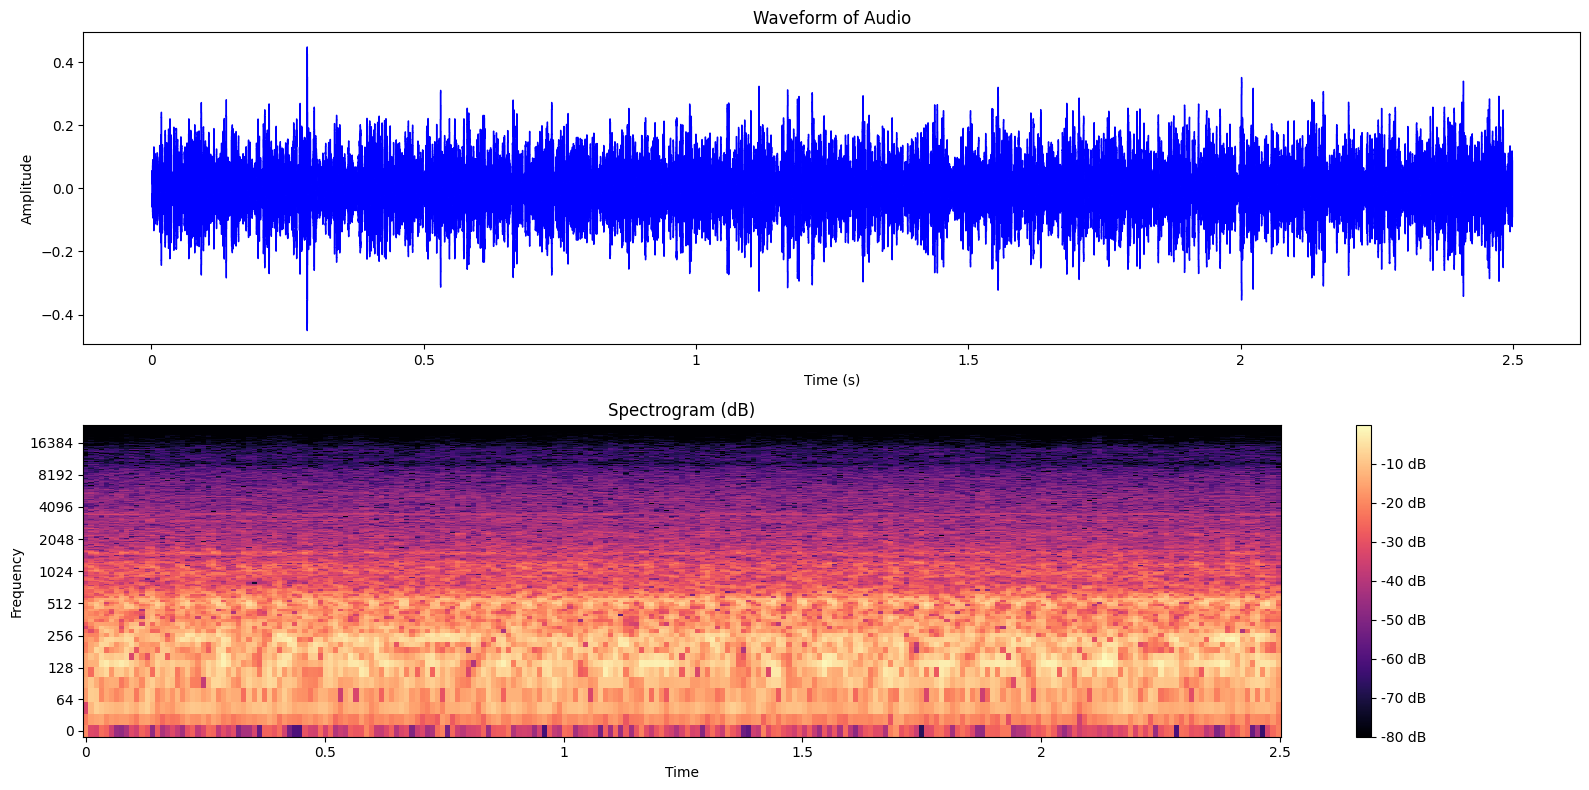

>>>> Audio of Car horn :


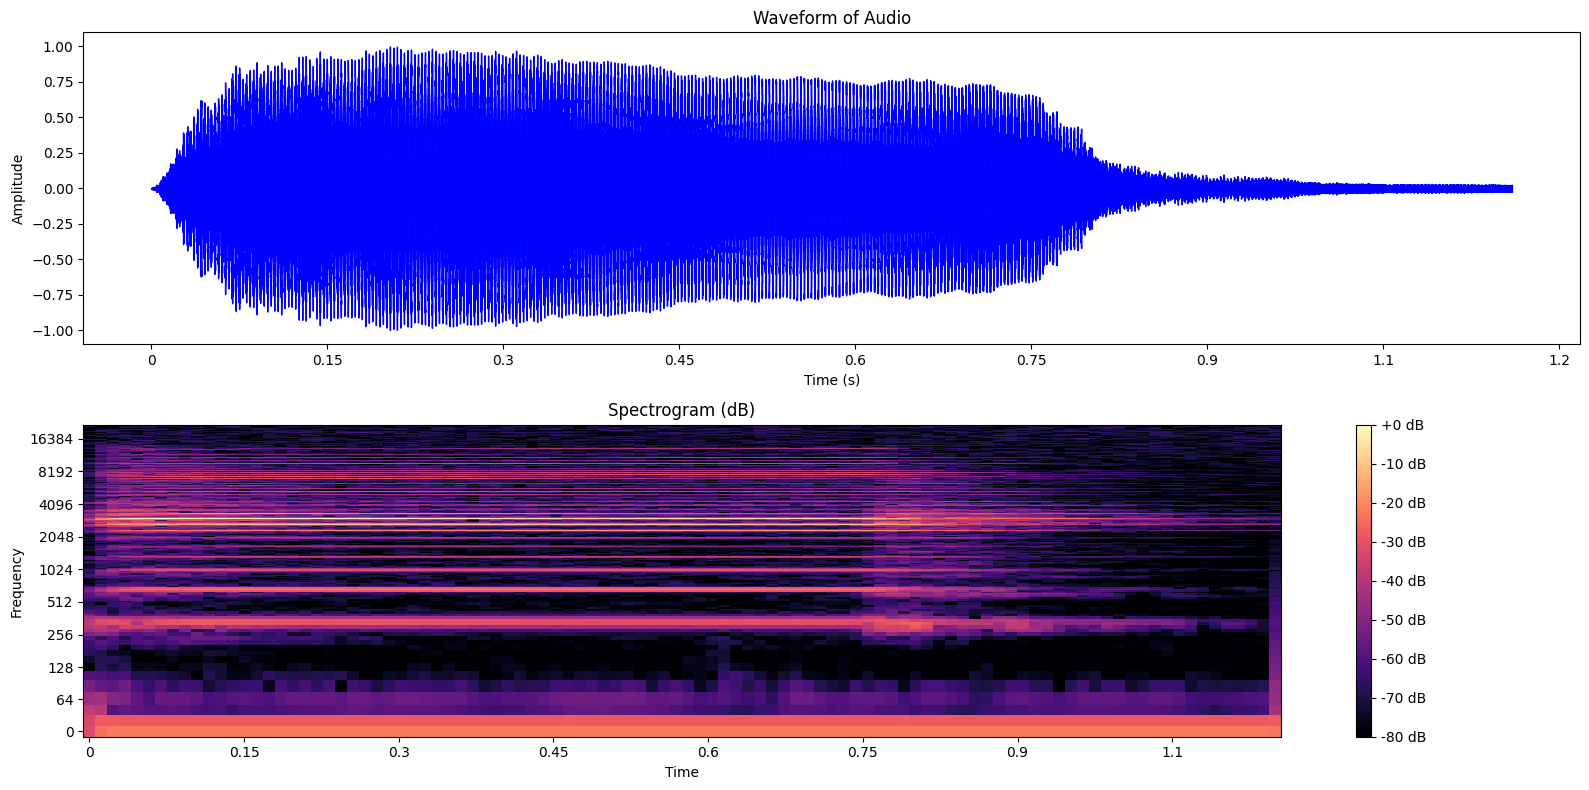

>>>> Audio of Children playing :


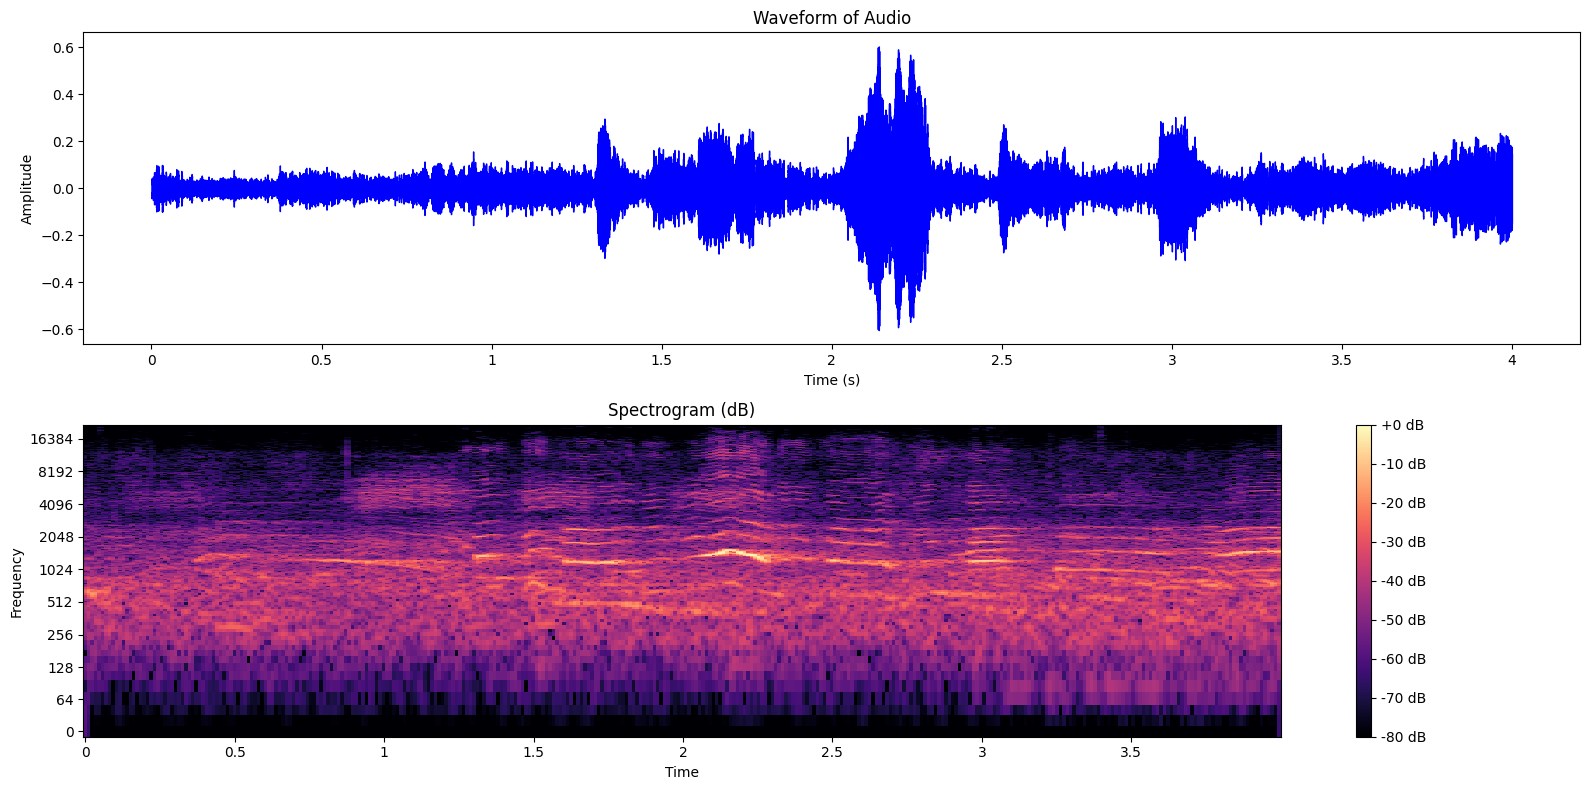

>>>> Audio of Dog bark :


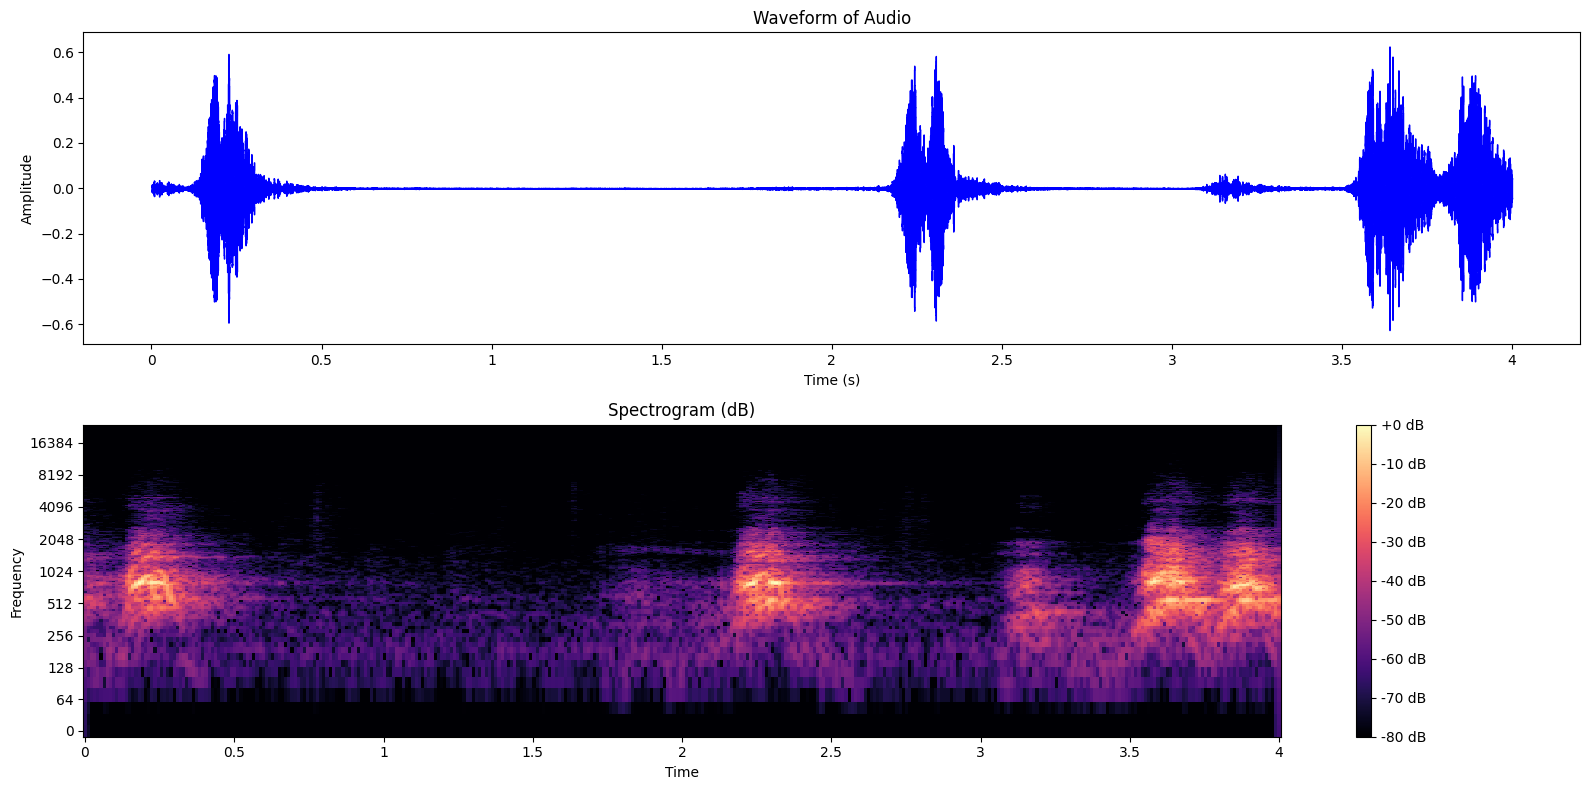

>>>> Audio of Drilling :


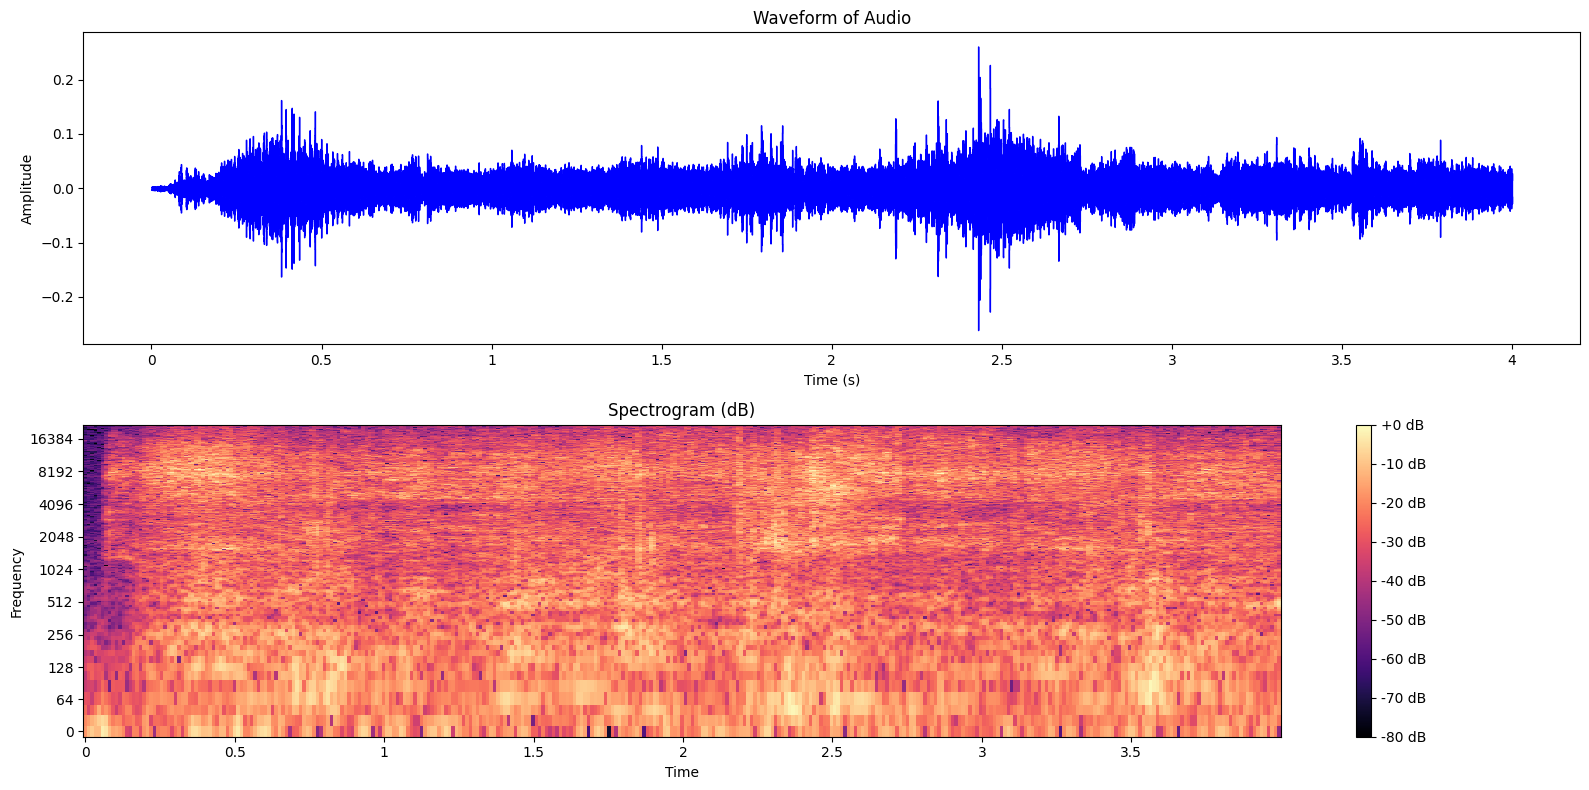

>>>> Audio of Engine idling :


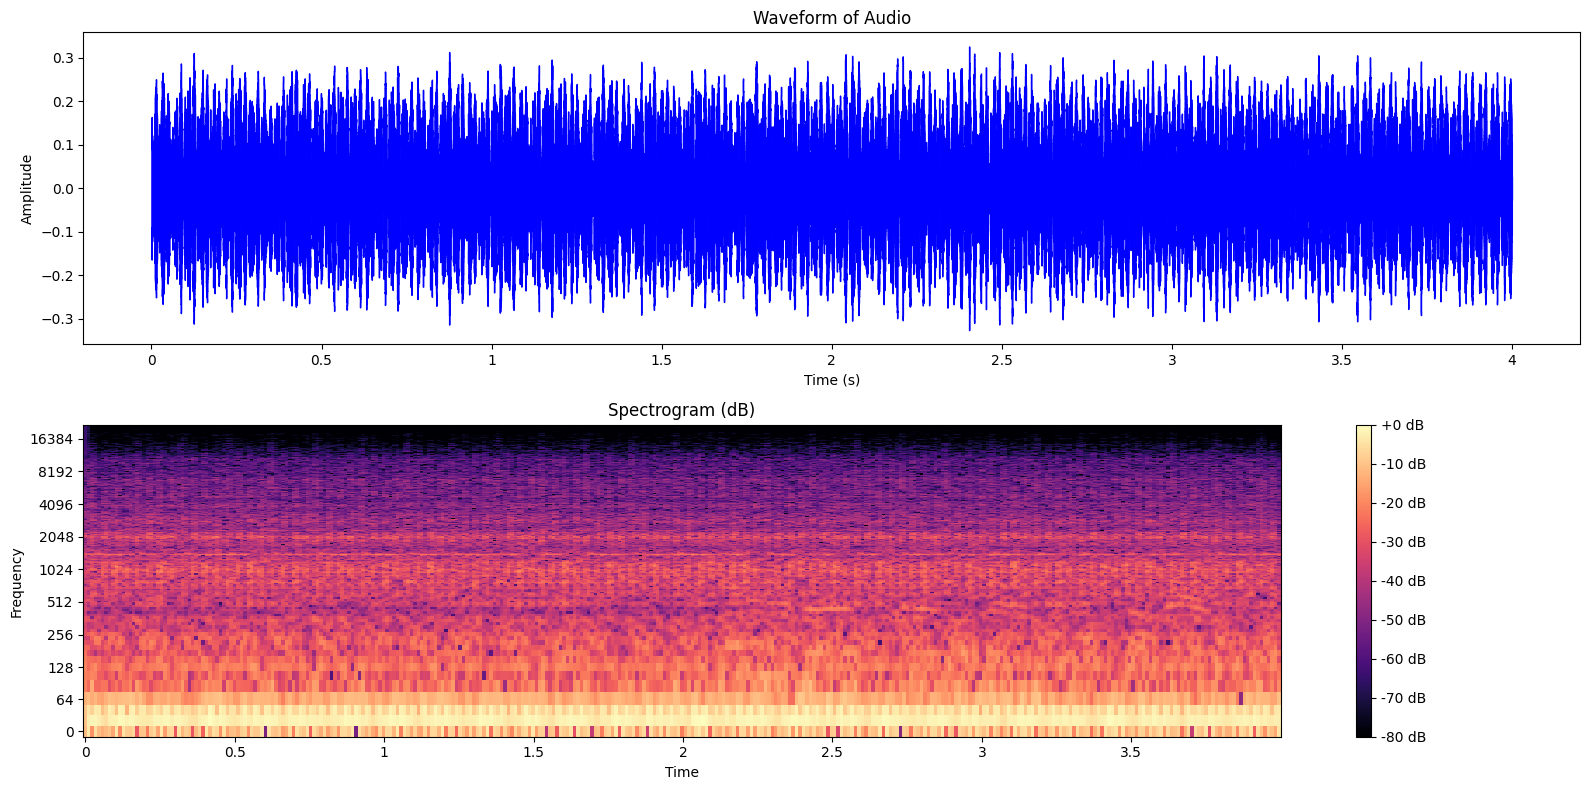

>>>> Audio of Gun shot :


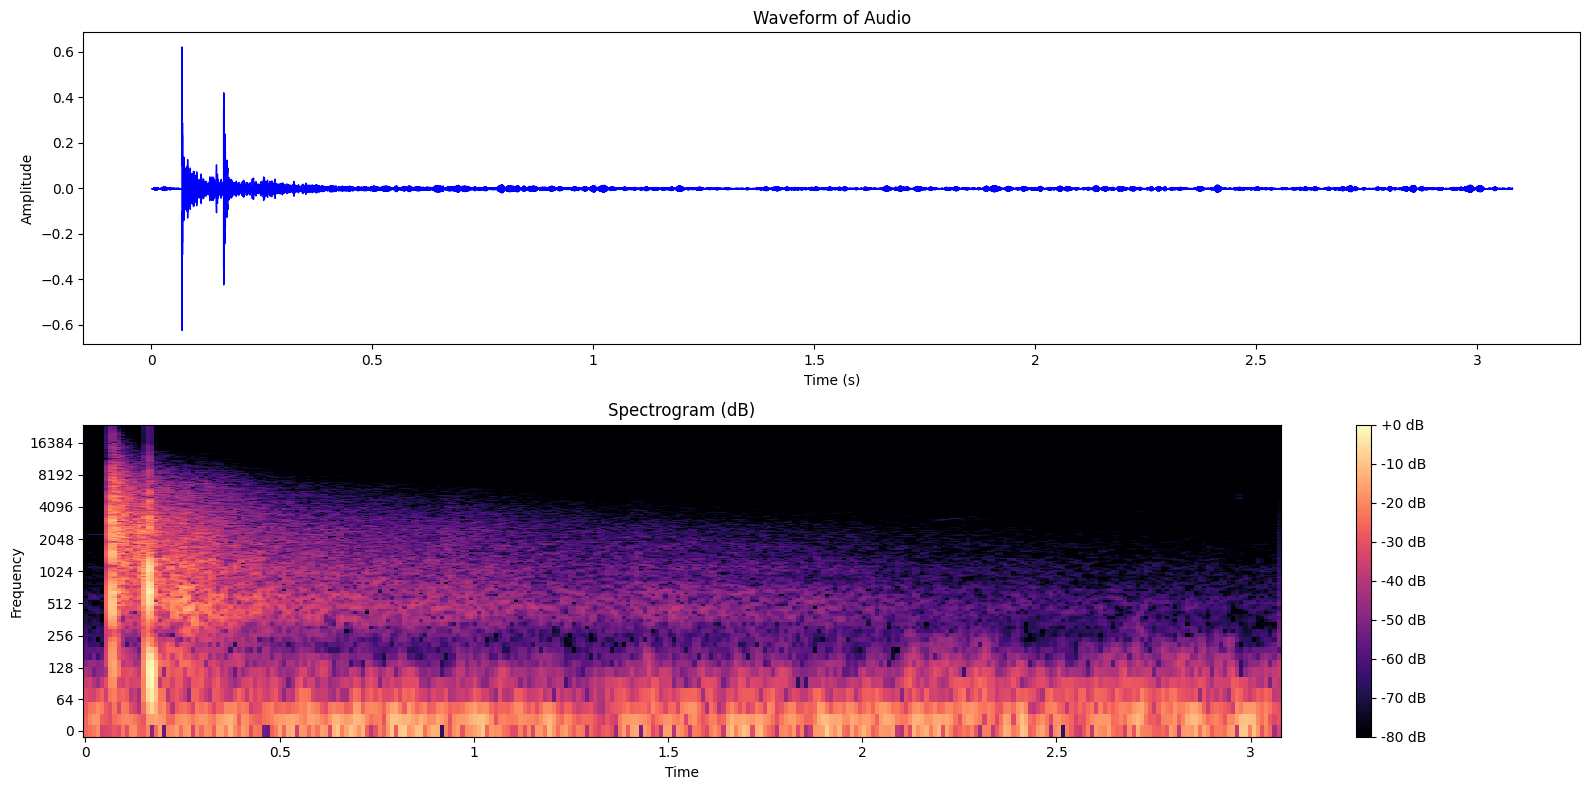

>>>> Audio of Jackhammer :


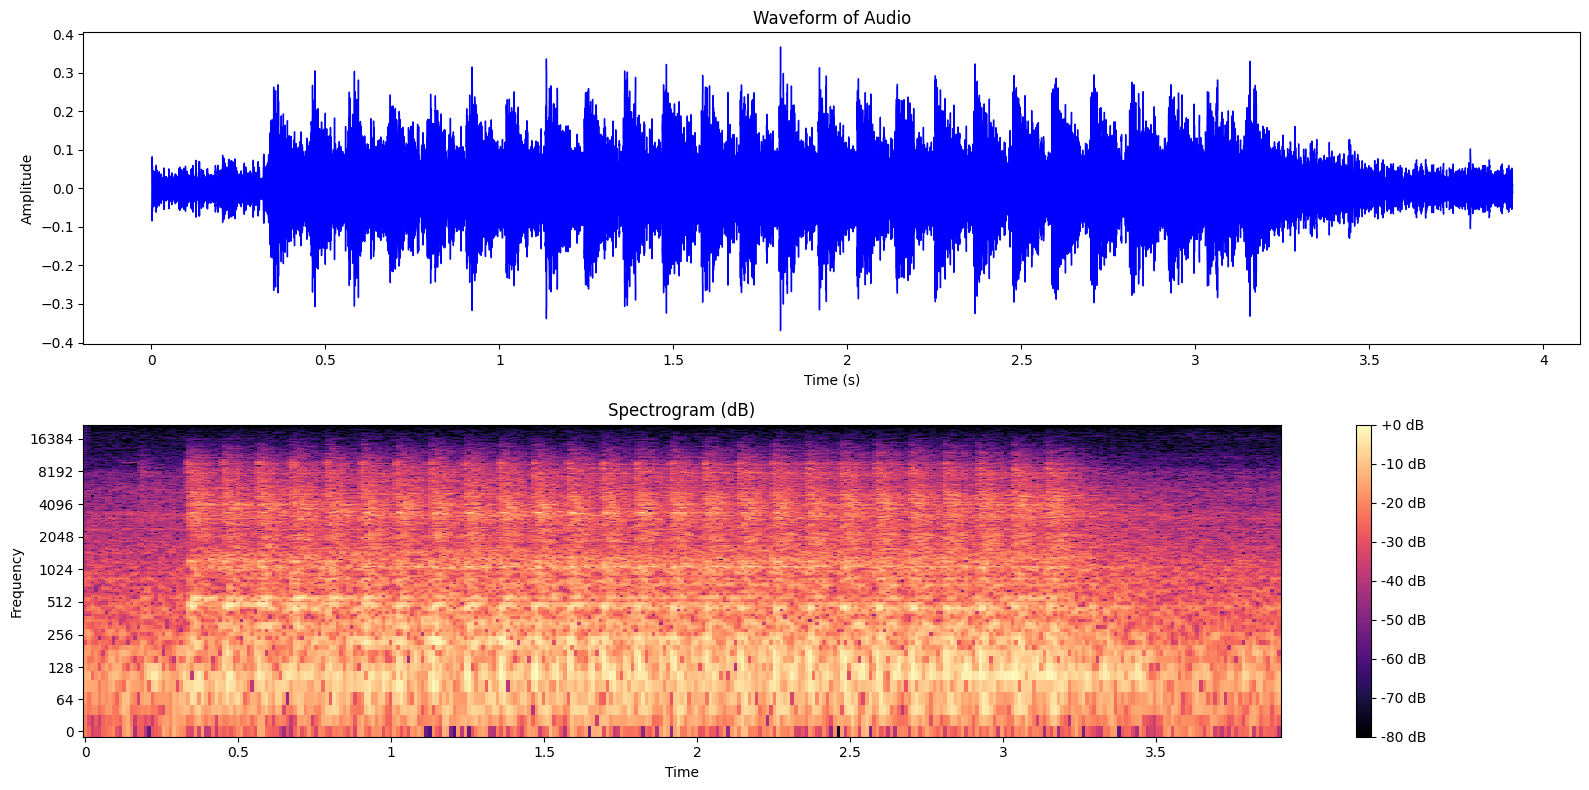

>>>> Audio of Siren :


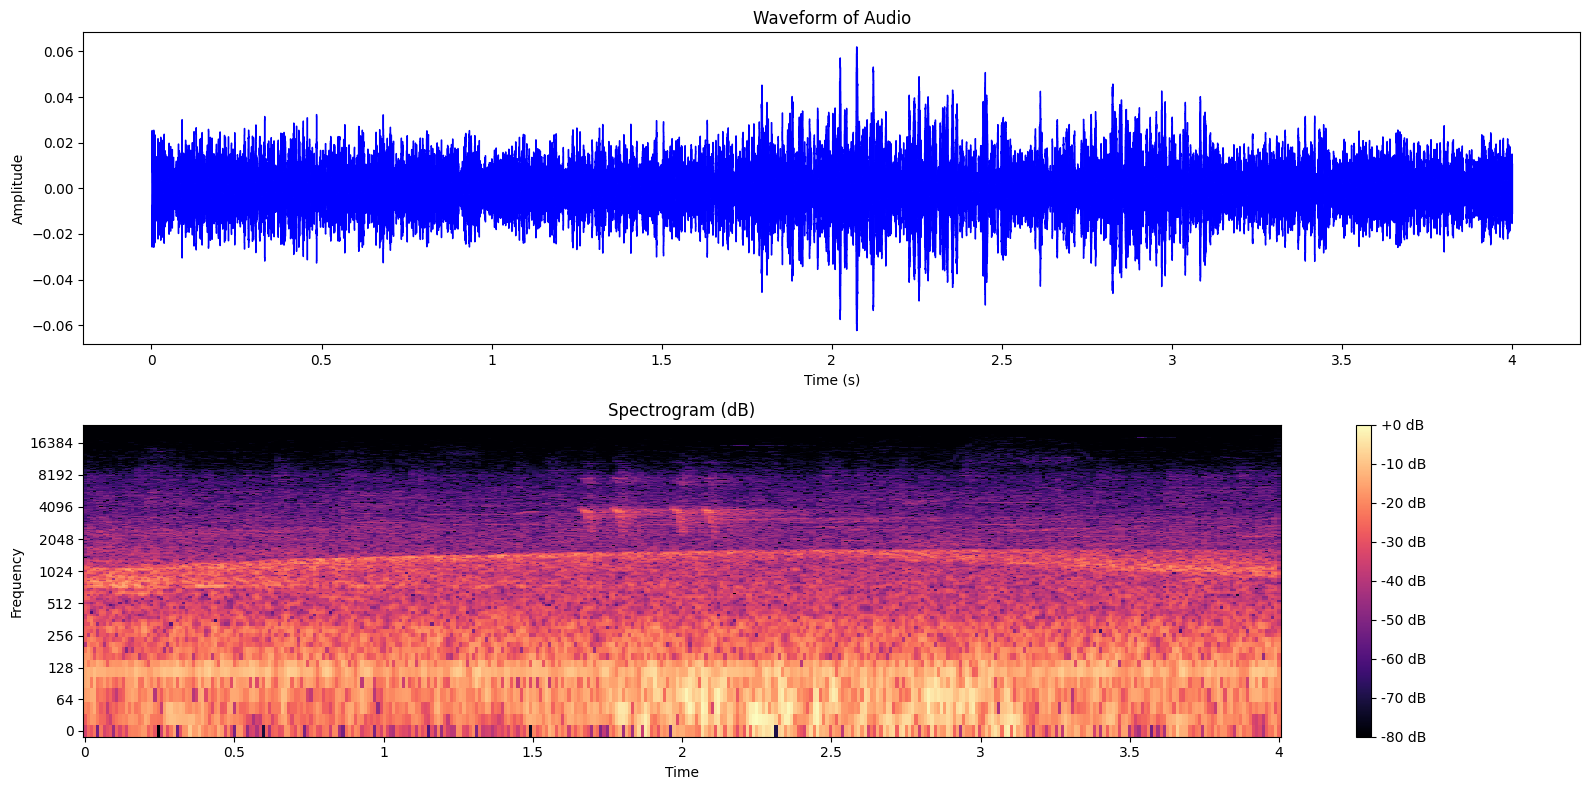

>>>> Audio of Street music :


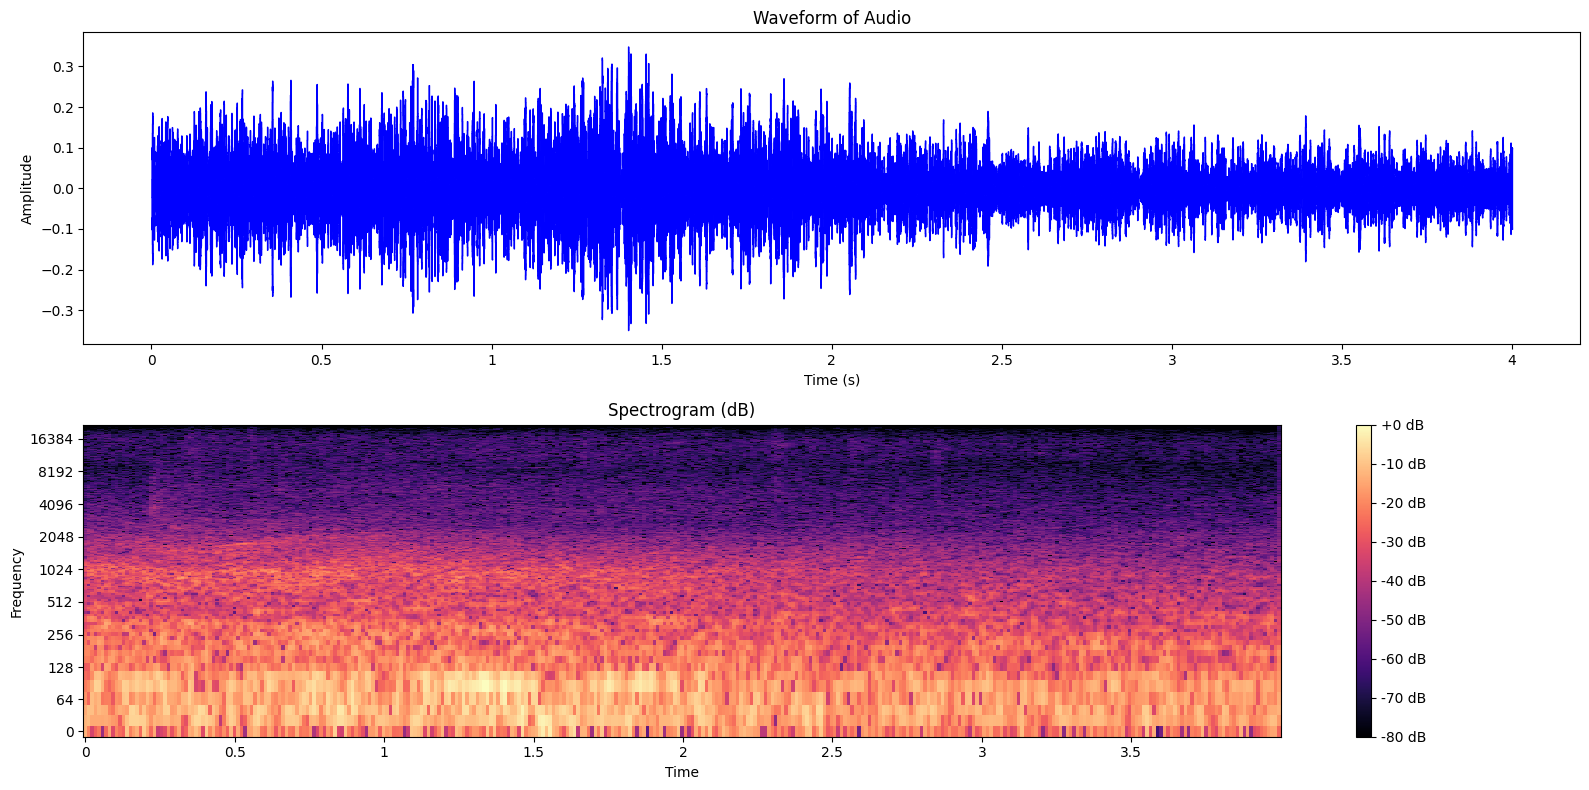

In [22]:
# Extract a sample from each class
random_samples_df = audio_df.groupby(by='class').sample(1)
random_samples_df = random_samples_df[['slice_file_name', 'fold', 'class']]

# Display the spectrogram of each class
for index, row in random_samples_df.iterrows():
    class_name = row['class'].replace('_', ' ').capitalize()
    file_path = os.path.join(data_dir, f'fold{row.fold}/{row.slice_file_name}')
    print(f'>>>> Audio of {class_name} :')
    visualize_audio(file_path)

## Step 5 : Load and Preprocess data

- ### Extract **MFCCs**

In [23]:

def extract_mfcc(file_path: str, n_mfcc: int = 50) -> list:
    """Extract MFCC features from a .wav audio file, trimming silence."""
    # Create a Path object
    file = Path(file_path)
    
    # Check if the file exists and has a .wav extension
    if not file.is_file() or file.suffix.lower() != '.wav':
        raise ValueError(f"{file_path} does not exist or is not a .wav file.")

    try:
        # Load the audio file
        sample, sample_rate = librosa.load(file_path, res_type='kaiser_fast', sr=None)  # Load the audio file

        # Check if the audio signal is empty
        if sample.size == 0:
            raise ValueError(f"The audio file {file_path} is empty.")

        # Trim the silence from the audio signal
        sample_trimmed, _ = librosa.effects.trim(sample, top_db=20)
        
    except Exception as e:
        raise RuntimeError(f"Error loading audio file {file_path}: {e}")

    # Extract MFCC features after trimming
    mfcc_feature = librosa.feature.mfcc(y=sample_trimmed, sr=sample_rate, n_mfcc=n_mfcc)

    # Scale the MFCC features by averaging over time
    return np.mean(mfcc_feature.T, axis=0)  # Mean across the time axis

In [28]:
def load_and_preprocess_data(data_dir: str = '/kaggle/input/urbansound8k') -> (np.ndarray, np.ndarray):
    """Load and preprocess audio data from the specified directory."""
    # Load the audio data
    csv_path = Path(data_dir) / 'UrbanSound8K.csv'

    # Read the CSV file
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"CSV file not found at {csv_path}. Please check the directory.")
    except pd.errors.EmptyDataError:
        raise ValueError("CSV file is empty.")
    except Exception as e:
        raise RuntimeError(f"An error occurred while reading the CSV file: {e}")

    # Check if the necessary columns exist
    required_columns = ['fold', 'slice_file_name', 'class']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' is missing in the DataFrame.")

    # Prepare lists to store MFCCs and classes
    mfccs = []
    classes = []

    # Extract MFCC features for each audio file
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc='Processing audio files'):
        file_path = os.path.join(data_dir, f'fold{row["fold"]}', row["slice_file_name"])
        
        try:
            mfcc_feature = extract_mfcc(file_path)
            if mfcc_feature is not None:  # Ensure that the MFCC extraction was successful
                mfccs.append(mfcc_feature)
                classes.append(row['class'])
        except Exception as e:
            print(f"Failed to process {file_path}: {e}")  # Print the error and continue processing

    # Convert lists to arrays
    return np.array(mfccs), np.array(classes)

In [29]:
# load_and_preprocess_data usage:
X, y = load_and_preprocess_data(data_dir)
print(f'> Shape of MFCC features  (X) : {X.shape}')
print(f'> Shape of Labels         (y) : {y.shape}')

Processing audio files:   0%|          | 0/8732 [00:00<?, ?it/s]

> Shape of MFCC features  (X) : (8732, 50)
> Shape of Labels         (y) : (8732,)


- ### Label encoding

In [30]:
le = LabelEncoder()
encoded_y = to_categorical(le.fit_transform(y))
print(f'> Shape of Encoded Labels : {encoded_y.shape}')

> Shape of Encoded Labels : (8732, 10)


## Step 6 : Split data into training and testing sets

In [32]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.2, random_state=123)
print(f'> Shape of Train Features : {X_train.shape}')
print(f'> Shape of Train Label    : {y_train.shape}')
print(f'> Shape of Test  Features : {X_test.shape}')
print(f'> Shape of Test  Label    : {y_test.shape}')

> Shape of Train Features : (6985, 50)
> Shape of Train Label    : (6985, 10)
> Shape of Test  Features : (1747, 50)
> Shape of Test  Label    : (1747, 10)


## Step 7 : Train an ANN model

- ### Create and compile an ANN model

In [33]:
from keras import Sequential, activations, layers, optimizers, losses

def create_ann_model(input_shape = X_train.shape[1], num_classes: int = 10, dropout_rate: float = 0.5, verbose: bool = True) -> Sequential:
    """Create and compile a feedforward neural network model with specified architecture."""
    # Create a neural network model
    model = Sequential()
    
    # Input Layer
    model.add(layers.Input(shape=input_shape))
    
    # Hidden Layers with Batch Normalization
    model.add(layers.Dense(128))
    model.add(layers.Activation(activations.relu))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(256))
    model.add(layers.Activation(activations.relu))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(256))
    model.add(layers.Activation(activations.relu))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(128))
    
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(), 
        loss=losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    # Summary the model if verbose is True
    if verbose:
        model.summary()
    
    return model  # Fixed the typo here

In [34]:
# Parameters
input_shape = (X_train.shape[1],)
dropout_rate = 0.5

# Create a RNN model
ann_model = create_ann_model(input_shape, num_classes, dropout_rate)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,530 (545.04 KB)

 Trainable params: 139,530 (545.04 KB)

 Non-trainable params: 0 (0.00 B)

- ### Fit the ANN model

In [35]:
# Parameters
epochs = 200 
batch_size = 64

# Train the model
ann_history = ann_model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test))

Epoch 1/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1144 - loss: 32.6653 - val_accuracy: 0.1940 - val_loss: 2.2098
Epoch 2/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1341 - loss: 3.5662 - val_accuracy: 0.1110 - val_loss: 2.2887
Epoch 3/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1620 - loss: 2.4609 - val_accuracy: 0.1093 - val_loss: 2.3017
Epoch 4/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1798 - loss: 2.2759 - val_accuracy: 0.1402 - val_loss: 2.2860
Epoch 5/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1821 - loss: 2.2423 - val_accuracy: 0.1317 - val_loss: 2.2993
Epoch 6/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2037 - loss: 2.1794 - val_accuracy: 0.1494 - val_loss: 2.2267
Epoch 7/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2203 - loss: 2.1411 - val_accuracy: 0.1929 - val_loss: 2.1554
Epoch 8/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2299 - loss: 2.1130 - val_acc

- ### Visualize the training history of ANN model

In [36]:
def plot_history(history=None, model_name: str = None, figure_directory: str = None, ylim_pad=[0, 0], figsize=(10, 10), show_grid=True):
    """Plot the training history of loss and R2 score with dual y-axes."""

    if history is None:
        raise ValueError(f"The {model_name}-history object must be provided.")

    x_labels = 'Epoch'

    # Creating a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=figsize)

    metrics = ['loss', 'accuracy']
    titles = ['Train', 'Validation']

    for i, title in enumerate(titles):
        # Prepare data
        y1 = history.history[metrics[0]] if title == 'Train' else history.history['val_loss']
        y2 = history.history[metrics[1]] if title == 'Train' else history.history['val_accuracy']

        ax1 = axs[i]
        
        # Plotting the loss
        ax1.plot(y1, label=f'{title} Loss', color='tab:blue')
        ax1.set_xlabel(x_labels)
        ax1.set_ylabel('Loss', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.set_title(f'{title} Loss and Accuracy per Epoch')
        ax1.legend(loc='lower left')
        
        # Create a second y-axis for the R² score
        ax2 = ax1.twinx()
        ax2.plot(y2, label=f'{title} Accuracy', color='tab:red')
        ax2.set_ylabel('Accuracy', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.legend(loc='upper left')

        # Optional ylim padding
        if ylim_pad:
            ax1.set_ylim([min(y1) - ylim_pad[0], max(y1) + ylim_pad[1]])
            ax2.set_ylim([min(y2) - ylim_pad[0], max(y2) + ylim_pad[1]])

        if show_grid:
            ax1.grid()

    fig.tight_layout()  # Adjust subplots to fit into figure area.

    if figure_directory:
        plt.savefig(f"{figure_directory}/{model_name}_training_history.png")  # Save to directory

    plt.show()

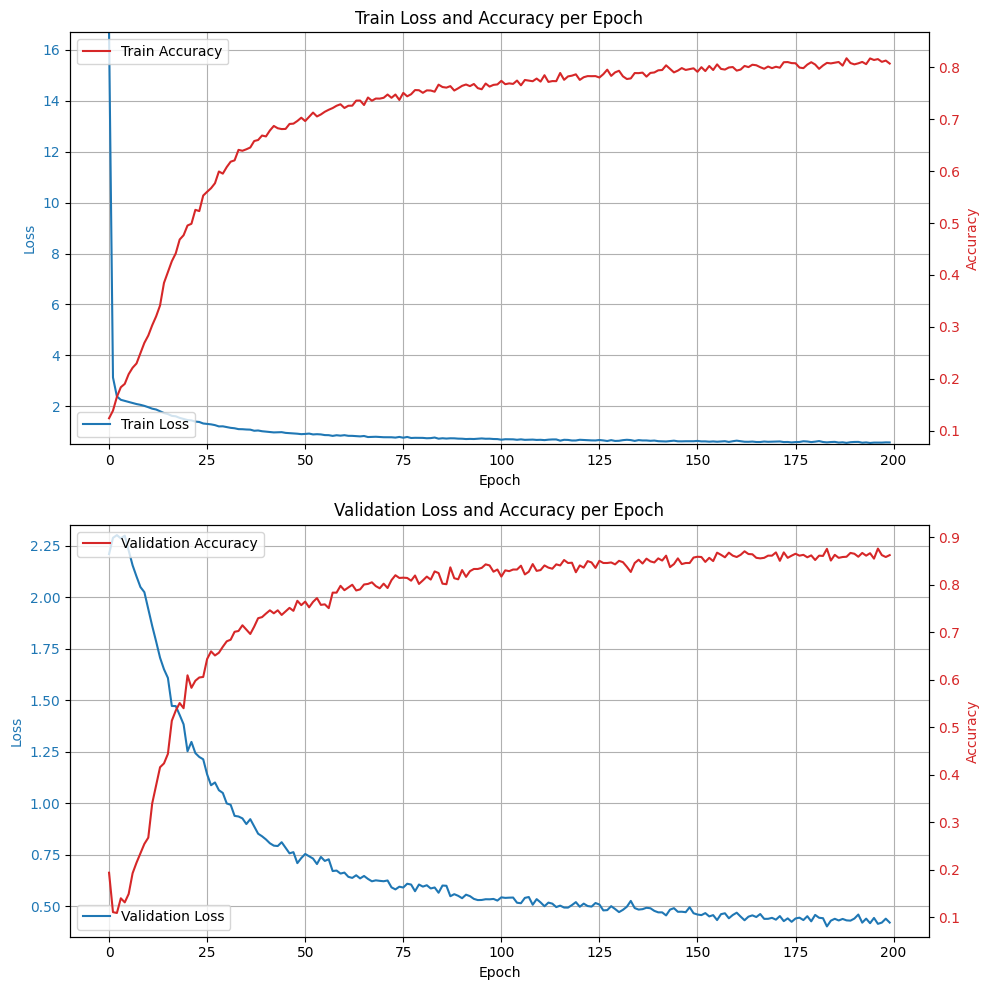

In [50]:
figure_dir = '/kaggle/working/'
model_name = 'ANN'

plot_history(history=ann_history, model_name=model_name, figure_directory=figure_dir, ylim_pad=[0.05, 0.05], figsize=(10, 10))

## Step 8 : Evaluate the ANN model

In [39]:
def evaluate_model(model, X_train, y_train, X_test, y_test, encoder):
    """Evaluates the performance of the model on training and testing data."""
    # Evaluate the model on training and testing data
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    # Print evaluation results
    print('>> Evaluation ')
    print(f'>  Train Loss     : {train_loss:.4f}')
    print(f'>  Train Accuracy : {train_acc * 100:.2f}%')
    print(f'>  Test  Loss     : {test_loss:.4f}')
    print(f'>  Test  Accuracy : {test_acc * 100:.2f}%')
    
    # Predict the labels for test data
    y_pred = model.predict(X_test)
    y_test = np.argmax(y_test, axis=1)  # Get the actual class labels
    y_pred = np.argmax(y_pred, axis=1)  # Get the predicted class labels

    # Generate classification report
    test_report = classification_report(y_test, y_pred)
    print(f'>  Classification Report:\n{test_report}')

    # Plotting confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize = (12, 6))
    sns.heatmap(matrix, annot = True, cbar = False, fmt = 'd', cmap = 'Blues', xticklabels = encoder.classes_, yticklabels = encoder.classes_)
    plt.title('Confusion Matrix', fontsize = 16)
    plt.xlabel('Predicted Class', fontsize = 14)
    plt.xticks(rotation = 30)
    plt.ylabel('Actual Class', fontsize = 14)
    plt.show()

>> Evaluation 
>  Train Loss     : 0.2676
>  Train Accuracy : 92.33%
>  Test  Loss     : 0.4217
>  Test  Accuracy : 86.26%
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
>  Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       186
           1       0.97      0.79      0.87        90
           2       0.65      0.89      0.75       202
           3       0.79      0.86      0.82       206
           4       0.97      0.88      0.92       192
           5       0.94      0.88      0.91       202
           6       0.94      0.75      0.84        81
           7       0.92      0.98      0.95       194
           8       0.94      0.92      0.93       185
           9       0.80      0.67      0.73       209

    accuracy                           0.86      1747
   macro avg       0.89      0.85      0.87      1747
weighted avg       0.88      0.86      0.86      1747



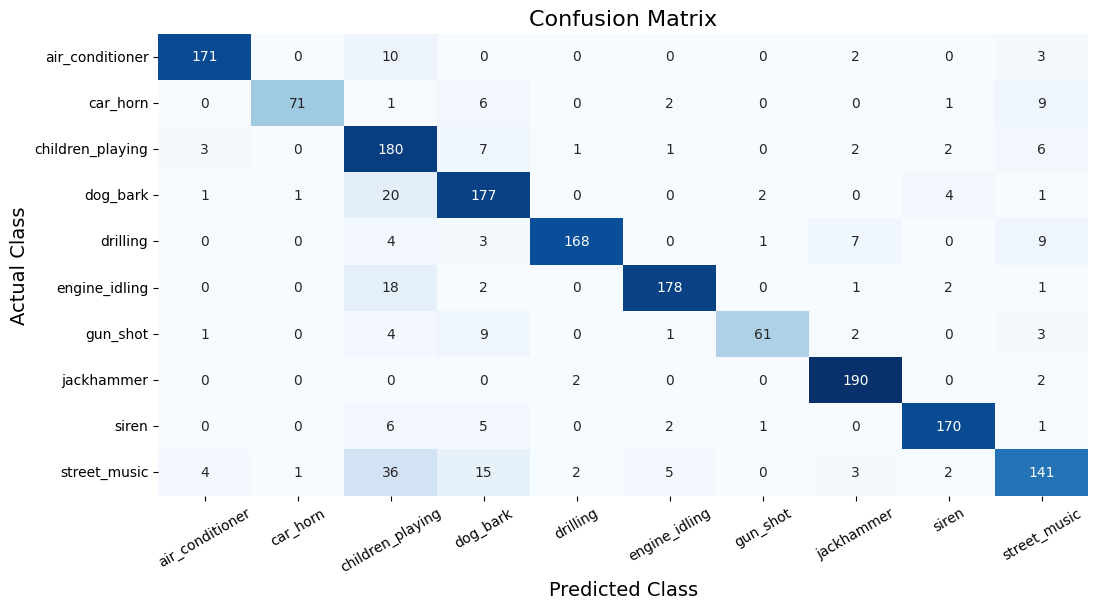

In [42]:
evaluate_model(ann_model, X_train, y_train, X_test, y_test, le)

## Step 9 : Visualize predictions

In [43]:
def print_prediction(model: Sequential, encoder: LabelEncoder, file_path: str) -> str:
    """Predict the class of an audio file using a trained model and decode the prediction."""
    if not os.path.isfile(file_path):
        raise ValueError(f"The file {file_path} does not exist or is not a valid file.")

    try:
        mfcc_feature = np.array([extract_mfcc(file_path)])
        class_pred = model.predict(mfcc_feature)
        vector_pred = np.argmax(class_pred, axis=1)
        class_pred_decoded = encoder.inverse_transform(vector_pred)

        print(f'> The predicted class of audio is : {class_pred_decoded}')
        return class_pred_decoded

    except Exception as e:
        raise RuntimeError(f"An error occurred during prediction: {str(e)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
> The predicted class of audio is : ['siren']
> Random Audio Sample 2648 :
> Actual    Class : Siren
> Predicted Class : Siren
>> Playing audio    : /kaggle/input/urbansound8k/fold10/159742-8-0-14.wav
>  Sample Rate      : 48000 Hz


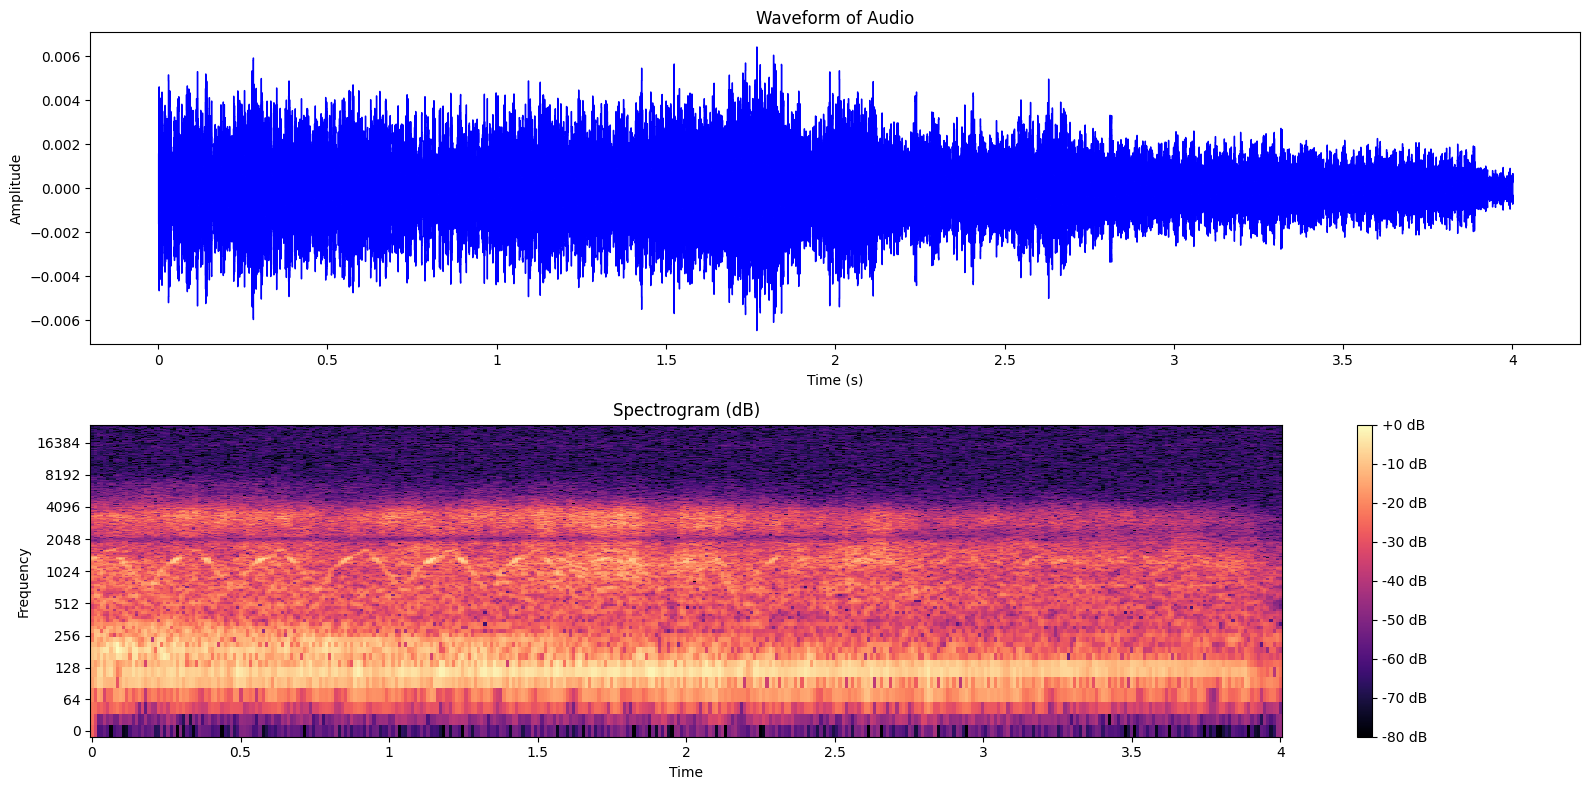

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
> The predicted class of audio is : ['drilling']
> Random Audio Sample 7288 :
> Actual    Class : Drilling
> Predicted Class : Drilling
>> Playing audio    : /kaggle/input/urbansound8k/fold3/66622-4-0-6.wav
>  Sample Rate      : 44100 Hz


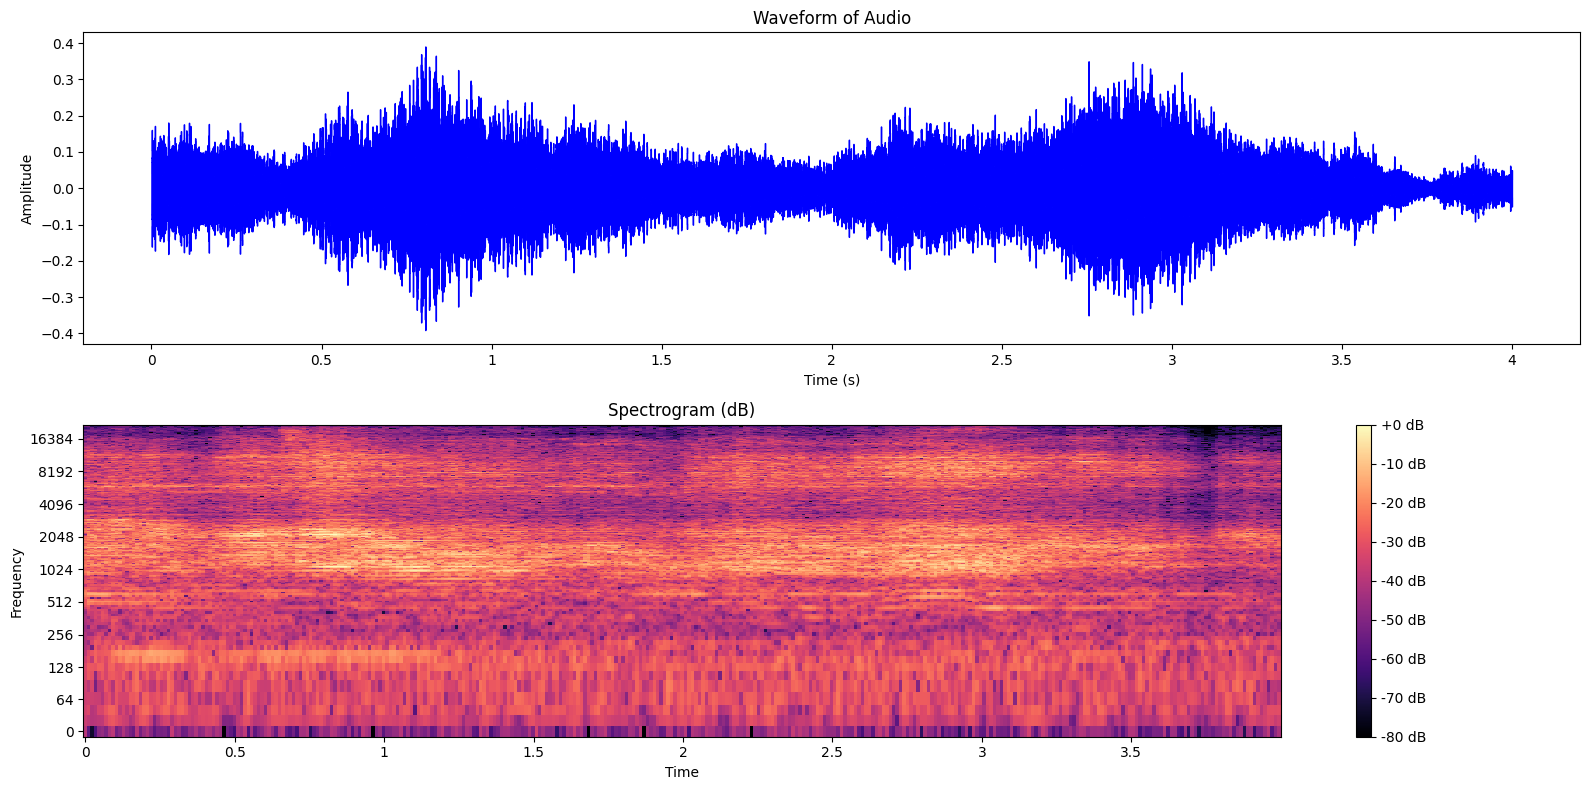

In [46]:
# Display the prediction of result
samples = audio_df.sample(2)
for index, row in samples.iterrows():
    class_name = row['class'].replace('_', ' ').capitalize()
    file_path = os.path.join(data_dir, f'fold{row.fold}/{row.slice_file_name}')
    class_name_pred = print_prediction(ann_model, le, file_path)[0]
    class_name_pred = class_name_pred.replace('_', ' ').capitalize()
    print(f'> Random Audio Sample {index + 1} :')
    print(f'> Actual    Class : {class_name}')
    print(f'> Predicted Class : {class_name_pred}')
    play_audio_file(file_path)
    visualize_audio(file_path)

## Step 10 : Save the ANN model

In [49]:
# Save the model
model_dir = '/kaggle/working/'
model_path = os.path.join(model_dir, 'audio_ann_model.keras')

ann_model.save(model_path)
print(f'> ANN model saved to {model_path}')

/kaggle/working/audio_ann_model.keras
> ANN model saved to /kaggle/working/audio_ann_model.keras
